In [2]:
## Math584 Math for Algo Trading - HW1
## Niti Wattanasirichaigoon
## A20406934

import pandas as pd
import numpy as np 
import csv
import matplotlib.pyplot as plt
import math
from pandas_datareader import data
import scipy.optimize
from scipy import stats

In [3]:
#read the list of tickers from file

tickers_file = 'TechTickers.csv'
tickers = [];
f = open(tickers_file,"r",encoding='utf-8-sig')
for line in csv.reader(f):
    tickers.append(str(line[0]))
f.close

<function TextIOWrapper.close()>

In [4]:
#download data from yahoo between the starting and ending dates

start_date = '2009-01-01'
end_date = '2019-12-31'
stock_data = data.get_data_yahoo(tickers, start_date, end_date)

In [5]:
#reformat the adj closing prices into a 2-dim array
stockArray = stock_data['Adj Close']
stockArray.head(7)

Symbols,AAPL,MSFT,TSM,INTC,CSCO,ORCL,SAP,ADBE,CRM,NVDA,...,IT,LDOS,ZBRA,TDY,OTEX,TYL,TER,FICO,JKHY,ASX
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,11.253528,15.635055,5.567235,10.736197,13.128983,16.029591,30.239336,23.020000,8.5050,8.021299,...,18.469999,27.678226,21.030001,45.310001,6.855640,11.99,4.409094,16.945189,16.817520,1.138912
2009-01-05,11.728474,15.781175,5.458869,10.531362,13.245105,15.750971,29.471380,23.129999,8.3375,8.168647,...,17.799999,27.973709,20.740000,46.119999,7.027365,11.62,4.881160,16.424543,16.636969,1.170374
2009-01-06,11.535025,15.965750,5.689144,10.856274,13.771499,16.012173,29.909039,24.219999,8.6500,8.444927,...,18.190001,27.833008,21.260000,46.220001,7.056360,11.68,5.069987,16.621016,16.877703,1.176666
2009-01-07,11.285772,15.004425,5.221822,10.199384,13.407664,15.367858,30.165018,24.230000,8.0000,7.938413,...,17.280001,27.607861,21.280001,43.250000,6.949308,11.51,4.947248,16.247725,16.757338,1.195543
2009-01-08,11.495339,15.473547,5.106684,10.277082,13.577968,15.341739,31.065092,24.290001,8.2275,7.735811,...,17.240000,27.678226,20.629999,43.419998,6.904705,11.57,5.145517,15.746738,16.869104,1.151497
2009-01-09,11.232448,15.012109,5.072821,9.994554,12.927711,15.115351,30.454041,24.010000,7.8825,7.302975,...,16.290001,27.326441,19.440001,41.540001,6.732979,11.64,4.947248,15.216283,16.722946,1.113743
2009-01-12,10.994360,14.973660,4.971229,9.740271,12.695475,14.845437,29.165850,23.760000,7.7125,7.008276,...,16.430000,26.876156,18.809999,41.090000,6.857870,11.76,4.777307,15.285044,16.310242,1.088574


In [6]:
#1a
#compute the sample mean returns and sample cov matrix and save them as csv files

returns = stockArray.pct_change()
meanReturns = returns.mean() * 250 #annualize
covMatrix = returns.cov() *250 #annualize
print(meanReturns)
print(covMatrix)

meanReturns.to_csv('meanReturns.csv', index=False, header=False)
covMatrix.to_csv ("covMatrix.csv", index=False, header=False)

Symbols
AAPL    0.329644
MSFT    0.238320
TSM     0.248356
INTC    0.188042
CSCO    0.150517
          ...   
TYL     0.328610
TER     0.317505
FICO    0.333973
JKHY    0.214494
ASX     0.212551
Length: 64, dtype: float64
Symbols      AAPL      MSFT       TSM      INTC      CSCO      ORCL       SAP  \
Symbols                                                                         
AAPL     0.069965  0.028875  0.031938  0.031070  0.030727  0.027085  0.026988   
MSFT     0.028875  0.058862  0.028681  0.035928  0.034267  0.031241  0.029143   
TSM      0.031938  0.028681  0.072916  0.036994  0.031617  0.029764  0.029578   
INTC     0.031070  0.035928  0.036994  0.066516  0.036019  0.030658  0.029801   
CSCO     0.030727  0.034267  0.031617  0.036019  0.067877  0.032942  0.029916   
...           ...       ...       ...       ...       ...       ...       ...   
TYL      0.024675  0.028447  0.025487  0.025034  0.028759  0.028108  0.028345   
TER      0.046226  0.043643  0.054854  0.056707  

In [7]:
#1b
#compute the weights of the minimal-variance portfolio and save as csv file

def objfnc(w, cov):
    w = np.matrix(w)
    cov = np.matrix(cov)
    return np.matmul(np.matmul(w,cov),w.T)

w0 = [1/len(meanReturns)] * len(meanReturns) #initial values
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w)-1.0}) #constraint
mvp_weights = scipy.optimize.minimize(objfnc, w0, args=covMatrix, method='SLSQP',constraints=cons)

print(mvp_weights.x)
print()
print(sum(mvp_weights.x))

np.savetxt('mvp_weights.csv', np.array(mvp_weights.x), delimiter=',')

[ 0.07066422  0.00371589  0.04775358  0.04370487 -0.00738551 -0.01514807
  0.04821442 -0.0451589  -0.02729806 -0.04017884  0.01920356 -0.02278345
  0.0507769   0.1452413   0.03531887  0.06497882 -0.01280709  0.01407973
 -0.0427474  -0.00292141 -0.00058655 -0.0235869   0.03672763 -0.0087969
  0.03277048 -0.06472587 -0.05843266 -0.0048962  -0.0326753   0.00061484
  0.14497751 -0.01789221  0.0535085  -0.00233766  0.03244589  0.03413677
 -0.06933932  0.03478466 -0.01957144  0.06085098  0.01918816  0.16111587
  0.01196404 -0.05927528 -0.02988751  0.03842033  0.00465743  0.11576085
  0.04491867 -0.01689272 -0.00284813 -0.00275353 -0.02229138  0.11450095
  0.00901097  0.07843138 -0.01292934 -0.00605868  0.08068754  0.03257924
 -0.07588755 -0.0676524   0.10834607  0.02169534]

1.0000000000000002


In [8]:
#1c
#compute the weights of the optimal mean-variance portfolio and save as csv file

def objfnc(w, mean, cov, gamma):
    w = np.matrix(w)
    m = np.array(mean)
    cov = np.matrix(cov)
    
    # return a negative value since scipy.optimize can only minimize
    return -(np.matmul(m,w.T) - gamma * np.matmul(np.matmul(w,cov),w.T))

w0 = [1/len(meanReturns)] * len(meanReturns) #initial values
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w)-1.0}) #constraint
gamma = 1
omvp_weights = scipy.optimize.minimize(objfnc, w0, (meanReturns, covMatrix, gamma), method='SLSQP',constraints=cons)

print(omvp_weights.x)
print()
print(sum(omvp_weights.x))

np.savetxt('omvp_weights.csv', np.array(omvp_weights.x), delimiter=',')

[ 1.50378959  0.65409613  0.41113662 -0.57328805 -0.57182281 -0.81636774
 -0.64631424  0.16872305  0.20322716  0.46006318  0.69592724  1.04761261
  0.67306474 -1.40711917 -0.65127392  0.58338724 -0.09480921  0.63662447
  0.28508896  0.11988438 -0.89628806  0.24280217 -0.14924125  0.18035092
  0.43448159 -0.1775223  -0.39310048 -0.02948673  0.49795686 -0.45593648
 -1.49267765 -0.61919869  0.67689318  0.18583891 -0.43758579 -0.12659839
 -0.1859795   0.22352416 -0.66500005  0.54971037 -0.27664278 -0.76681501
 -0.25264212  0.32142877  0.77873138  0.05876459 -0.46160818 -0.0916379
 -0.09316124  0.59510481 -0.46803266 -0.20034569 -0.13629886  0.66508436
  0.13708335 -0.45408122  0.32562715 -0.3318269   0.10751037  1.08756775
  0.03584529  0.54483988 -0.10286236 -0.06620583]

1.000000000000002


mean: 2.1421078889022946
variance: 1.0257762947727276


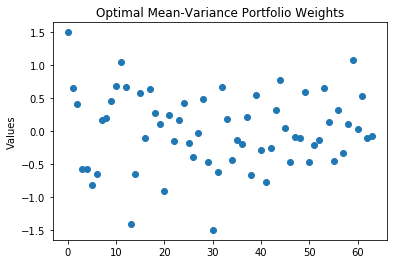

In [9]:
#plot weights for the optimal portfolio, calculate mean and variance

mean = np.dot(omvp_weights.x, meanReturns)
weights = np.matrix(omvp_weights.x)
covM = np.matrix(covMatrix)
var = np.matmul(np.matmul(weights, covM), weights.T)[0,0]

print("mean: " + str(mean))
print("variance: " + str(var))

plt.plot(weights.T,'o')
plt.ylabel('Values')
plt.title('Optimal Mean-Variance Portfolio Weights')
plt.show()

In [10]:
#1d
#compute the weights of the optimal mean-variance portfolio with robustness 
#(within one standard deviation) and save as csv file

def objfnc(w, mean, cov, gamma):
    w = np.matrix(w)
    m = np.array(mean)
    cov = np.matrix(cov)
    sd = np.sqrt(np.diag(cov))
    
    # return a negative value since scipy.optimize can only minimize
    return -(np.matmul(m,w.T) - np.matmul(abs(w),sd.T) - gamma * np.matmul(np.matmul(w,cov), w.T))

w0 = [1/len(meanReturns)] * len(meanReturns) #initial values
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w)-1.0}) #constraint
gamma = 1
omvp_robust_weights = scipy.optimize.minimize(objfnc, w0, (meanReturns, covMatrix, gamma), method='SLSQP',constraints=cons)

print(omvp_robust_weights.x)
print()
print(sum(omvp_robust_weights.x))

np.savetxt('omvp_robust_weights.csv', np.array(omvp_robust_weights.x), delimiter=',')

[ 4.79356975e-01  7.11337440e-04  6.65910577e-04  1.52922074e-04
 -4.38566783e-05  9.43573278e-05  2.65575616e-04  7.42304551e-05
  3.54791544e-04 -3.54937561e-06  8.68881849e-04 -4.05752345e-05
  1.53607182e-06  1.86761985e-04  8.98364205e-06  2.46930624e-04
 -4.43889681e-05  3.88748668e-04  2.34831300e-05  5.89168964e-06
  3.91081516e-04 -2.15985655e-06  1.06669766e-04  1.95814461e-05
 -7.79265929e-06  1.44753585e-04  1.15113225e-04  9.99797728e-05
  7.05420070e-05  4.33133962e-06 -1.46753510e-05 -3.11356588e-05
  3.56434012e-04  1.33271468e-04  5.77235375e-05 -4.28906479e-05
 -3.49493128e-05  4.82636305e-05  1.05657092e-04  2.60877537e-04
  6.79239950e-04  1.73891561e-05  8.54114096e-05  1.29494969e-04
  8.43839696e-04  2.91477613e-04 -5.05022265e-05  6.86149761e-05
  7.73252675e-05  1.69338285e-05 -1.10028329e-05  3.09058982e-05
  2.50817435e-05  1.75615446e-01  3.83619909e-04  8.02801122e-05
  1.83531660e-04  3.36274793e-07  3.69283154e-05  3.09029659e-01
  4.09661281e-05  8.91474

mean lower bound: 0.052785016216203746
mean upper bound: 0.5670706106640204
variance: 0.04021906607826653


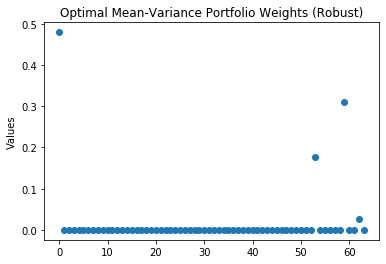

In [11]:
#plot weights for the optimal portfolio in robust setting, calculate mean and variance

sd = np.sqrt(np.diag(np.matrix(covMatrix)))
mean_low = np.dot(omvp_robust_weights.x, meanReturns-sd)
mean_high = np.dot(omvp_robust_weights.x, meanReturns+sd)
weights = np.matrix(omvp_robust_weights.x)
covM = np.matrix(covMatrix)
var = np.matmul(np.matmul(weights, covM), weights.T)[0,0]

print("mean lower bound: " + str(mean_low))
print("mean upper bound: " + str(mean_high))
print("variance: " + str(var))

plt.plot(weights.T,'o')
plt.ylabel('Values')
plt.title('Optimal Mean-Variance Portfolio Weights (Robust)')
plt.show()

In [12]:
#1e
#plot the efficient frontier and the individual basic assets
#first we need to calculate the corresponding standard deviations for each mean in [0,1]

def objfnc(w, cov):
    w = np.array(w)
    cov = np.matrix(cov)
    return np.matmul(np.matmul(w,cov),w.T)/2

w0 = [1/len(meanReturns)] * len(meanReturns) #initial values
def effFrontier(targetMean):
    # this function calculates the weights of the target mean value
    weights = scipy.optimize.minimize(objfnc, w0, covMatrix, method='SLSQP',
                                      constraints=({'type': 'eq', 'fun': lambda w:  np.sum(w)-1.0},
                                                   {'type': 'eq', 'fun': lambda w:  np.dot(w,meanReturns)-targetMean}))
    return weights.x

#iterate over 0 to 1 (step=0.01) calculating the standard deviations from the weights
ef_means = np.arange(0,1.01,0.01).tolist()
ef_sd = []

# ***this process takes about 30 seconds to run***
for targetMean in ef_means:
    weights = effFrontier(targetMean)
    var = np.matmul(np.matmul(weights, np.array(covMatrix)), weights.T)
    ef_sd.append(np.sqrt(var))

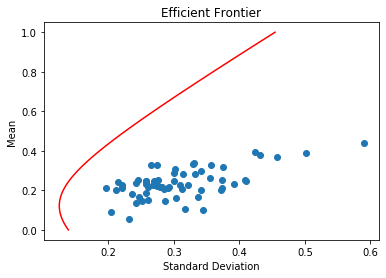

In [13]:
#plot the efficient frontier and the assets by means vs SD

plt.plot(ef_sd, ef_means,'r', sd, meanReturns, 'o')
plt.title('Efficient Frontier')
plt.ylabel('Mean')
plt.xlabel('Standard Deviation')
plt.show()

In [15]:
#1f
#compute weights of the portfolio - Optimal Mutual Funds
#assuming a riskless return of 0.01

risklessRet = 0.01
cov = np.matrix(covMatrix)
omf_weights = np.linalg.solve(cov, (meanReturns - risklessRet))
omf_weights = omf_weights/sum(omf_weights)

np.savetxt('omf_weights.csv', omf_weights, delimiter=',')

In [16]:
#compute the efficient frontier of market with riskless asset
#the length of weights and returns now becomes d+1 instead of d

extended_Returns = np.append(np.array([risklessRet]), meanReturns)

def objfnc(w, cov):
    rw = w[0]
    w = np.array(w)[1:]
    cov = np.matrix(cov)
    return np.matmul(np.matmul(w,cov),w.T)/2

w0 = [1/len(extended_Returns)] * len(extended_Returns) #initial values
def omf_ef(targetMean):
    # this function calculates the weights of the target mean value
    weights = scipy.optimize.minimize(objfnc, w0, covMatrix, method='SLSQP',
                                      constraints=({'type': 'eq', 'fun': lambda w:  np.sum(w)-1.0},
                                                   {'type': 'eq', 'fun': lambda w:  np.dot(w,extended_Returns)-targetMean}))
    return weights.x

#iterate over 0 to 1 (step=0.01) calculating the standard deviations from the weights
extended_means = np.arange(0,1.01,0.01).tolist()
extended_sd = [] 

# ***this process takes about 30 seconds to run***
for targetMean in extended_means:
    weights = omf_ef(targetMean)[1:] #excluding the weight of the riskless asset
    variance = np.matmul(np.matmul(weights, np.array(covMatrix)), weights.T)
    extended_sd.append(np.sqrt(variance))

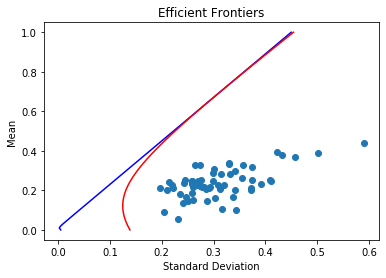

In [17]:
#plot the efficient frontier of e and the extended market

#Capital market line (eff frontier with riskless asset) in blue
#efficient frontier from part e in red
plt.plot(extended_sd, extended_means, 'b', ef_sd, ef_means, 'r', sd, meanReturns, 'o')
plt.title('Efficient Frontiers')
plt.ylabel('Mean')
plt.xlabel('Standard Deviation')
plt.show()

In [18]:
#2a
#compute CAPM betas of each asset

betas = (np.dot(cov, omf_weights))/(np.matmul(np.matmul(omf_weights, cov), omf_weights.T))[0,:]
print(betas)

np.savetxt('betas.csv', betas.T, delimiter=',')

[[0.4733757  0.33813062 0.35299314 0.26367038 0.20809864 0.18803808
  0.22935481 0.40809819 0.47369299 0.56912791 0.29801644 0.48418261
  0.3496845  0.11754835 0.20058307 0.32248601 0.23482095 0.35935531
  0.56383498 0.3628253  0.32507785 0.63386495 0.31807664 0.42967044
  0.35486493 0.37083595 0.30294481 0.30697326 0.3341337  0.14163767
  0.06806827 0.13531568 0.35032658 0.40496947 0.31426982 0.30749612
  0.34799312 0.36251453 0.22682506 0.34931344 0.32772914 0.28527899
  0.35761902 0.54382302 0.43925386 0.31869145 0.28251287 0.2577547
  0.31039516 0.53134452 0.29260991 0.32618487 0.28210197 0.34186993
  0.32544273 0.20123324 0.40130943 0.30796971 0.29352483 0.47184446
  0.45539886 0.47978796 0.30284489 0.29996755]]


In [19]:
#2b
#Regression with CAPM

dailyR = risklessRet / 250
# ri = excess returns of individual assets
ri = returns[1:] - dailyR
#normalize 
# rm = market excess returns
rm = []
for i in range(1, len(returns)):
    rm.append(np.dot(np.array(returns[i:i+1]), omf_weights)[0] - dailyR)

beta = []
p_val = []
aibi = []

#regression for each asset
for ticker in tickers:
    slope, intercept, r, p, se = stats.linregress(rm, np.array(ri[[ticker]].values).T.tolist()[0])
    aibi.append((intercept, slope))
    beta.append(slope)
    p_val.append(p)
    
np.savetxt('aibi.csv', aibi, delimiter =',')

In [21]:
#2c
#Regression with an additional factor
# f = average return of past 5 days (the first four days will be excluded)
# output coefficients are ai and ci

ri = returns[1:]
aici = []
p_val_f = []

#regression for each asset
ticker_ind = 0
for ticker in tickers:
    f = []
    
    #calculate the mean returns for the past 5 days
    priorR = np.array(ri[[ticker]].rolling(5).mean())
    for i in range(5, len(priorR)):
        f.append(priorR[i-1:i,0][0])
    
    # calculate hedged return = ri - bi(rm)
    hedgedR = (np.array(ri[[ticker]])[0] - dailyR - np.array([beta[ticker_ind] * ret for ret in rm]))[5:].tolist()
    slope, intercept, r, p, se = stats.linregress(f, hedgedR)
    aici.append((intercept, slope))
    p_val_f.append(p)
    ticker_ind += 1
    
np.savetxt('aici.csv', aici, delimiter =',')

significant = sum([pval<0.05 for pval in p_val_f])
print("Assets with significant p-vals: " + str(significant))

Assets with significant p-vals: 27


In [22]:
#2d
#Regression with an volume weighted average return of prior 5 days
# output coefficients are ai and ci2

# ri = returns of individual assets
ri = returns[1:]
volumes = stock_data['Volume'][1:]
aici2 = []
p_val_fv = []

#regression for each asset
ticker_ind = 0
for ticker in tickers:   
    f = []
    
    #calculate the volume weighted rolling mean returns
    priorR = np.array(ri[[ticker]])
    priorV = np.array(volumes[[ticker]])
    for i in range(5, len(priorR)):
        VweightedRet = np.dot(priorR[i-5:i,0], priorV[i-5:i,0])/sum(priorV[i-5:i,0])
        f.append(VweightedRet)

    # calculate hedged return = ri - bi(rm)
    hedgedR = (np.array(ri[[ticker]])[0] - dailyR - np.array([beta[ticker_ind] * ret for ret in rm]))[5:].tolist()
    slope, intercept, r, p, se = stats.linregress(f, hedgedR)
    aici2.append((intercept, slope))
    p_val_fv.append(p)
    ticker_ind += 1

np.savetxt('aici2.csv', aici2, delimiter =',')

significant = sum([pval<0.05 for pval in p_val_fv])
print("Assets with significant p-vals: " + str(significant))

Assets with significant p-vals: 22


In [48]:
#2e
#perform regression like in 2c and 2d but with only on sample where factor's value is above threshold
#threshold = (mean of factor) + lamba * (SD of factor)
#f1 = factor 1 (2c), f2 = factor 2 (2d)
#store optimal p-values and mean hedged excess returns for each asset and factor

# 10 values of lambdas distributed from 0 to 1 (0.0, 0.1,..., 0.9)
Lambdas = np.arange(0, 1, 0.1)

p_values = np.zeros((64,2)) # p-vals for 64 assets & 2 factors
meanHedged = np.zeros((64,2)) # mean excess hedged returns for 64 assets & 2 factors

#indices for days corresponding to the lambda that give best p-val
best_indices_f1 = []
best_indicies_f2 = []

#regression for each asset
ticker_ind = 0
for ticker in tickers:
    bestLambda_f1 = 0
    bestLambda_f2 = 0
    min_pval_f1 = 1
    min_pval_f2 = 1
    
    # calculate hedged return = ri - bi(rm)
    hedgedR = (np.array(ri[[ticker]])[0] - dailyR - np.array([beta[ticker_ind] * ret for ret in rm]))
    
    #calculate the mean returns for the prior 5 days
    priorR = np.array(ri[[ticker]].rolling(5).mean())
    f1_mean = np.nanmean(priorR[0:-1,0])
    f1_std = np.nanstd(priorR[0:-1,0])
    
    #calculate the volume weighted rolling mean returns
    VweightedReturns = []
    priorRet = np.array(ri[[ticker]])
    priorV = np.array(volumes[[ticker]])
    for i in range(5, len(priorRet)):
        VRet = np.dot(priorRet[i-5:i,0], priorV[i-5:i,0])/sum(priorV[i-5:i,0])
        VweightedReturns.append(VRet)
        
    VweightedReturns = np.array(VweightedReturns)
    f2_mean = np.mean(VweightedReturns)
    f2_std = np.std(VweightedReturns)
    
    for Lambda in Lambdas:
        #for each lambda, get indices of days where factors above the threshold for each factor
        indices_f1 = []
        indices_f2 = []
        threshold_f1 = f1_mean + Lambda * f1_std
        threshold_f2 = f2_mean + Lambda * f2_std
        
        for i in range(5, len(priorR)):
            if priorR[i-1:i,0][0] > threshold_f1:
                indices_f1.append(i)
            if VweightedReturns[i-5] > threshold_f2:
                indices_f2.append(i)
        
        indices_f1 = np.array(indices_f1)
        indices_f2 = np.array(indices_f2)
        
        #store best p-val for f1
        slope, intercept, r, p, se = stats.linregress(priorR[indices_f1-1,0].tolist(), hedgedR[indices_f1].tolist())
        if p < min_pval_f1:
            min_pval_f1 = p
            bestLambda_f1 = Lambda
            best_indices_f1 = indices_f1
        
        #store best p-val for f2
        slope, intercept, r, p, se = stats.linregress(VweightedReturns[indices_f2-5].tolist(), hedgedR[indices_f2].tolist())
        if p < min_pval_f2:
            min_pval_f2 = p
            bestLambda_f2 = Lambda
            best_indices_f2 = indices_f2
    
    #store the p-values and mean excess hedged returns mean((Ri - R) - bi(Rm - R))
    p_values[ticker_ind,0] = min_pval_f1
    p_values[ticker_ind,1] = min_pval_f2
    meanHedged[ticker_ind,0] = np.mean(hedgedR[best_indices_f1])
    meanHedged[ticker_ind,1] = np.mean(hedgedR[best_indices_f2])
    
    ticker_ind += 1
    #print("finished asset " + str(ticker_ind))
meanHedged = meanHedged * 250 #annualize      

In [114]:
#save data
np.savetxt("p_values.csv", p_values, delimiter = ',')
np.savetxt("meanHedged.csv", meanHedged, delimiter = ',')

# mean excess returns for basic assets
np.savetxt("meanExcessReturns.csv", np.array(meanReturns - risklessRet), delimiter = ',')

In [105]:
#Computing Sharpe ratios
# Sharpe ratio = (Mean return - Riskless return)/SD

mean_f1 = returns[1:].iloc[best_indices_f1].mean() * 250
mean_f2 = returns[1:].iloc[best_indices_f2].mean() * 250

cov_f1 = returns[1:].iloc[best_indices_f1].cov()
cov_f2 = returns[1:].iloc[best_indices_f2].cov()

sd_f1 = np.sqrt(np.diag(cov_f1) * 250)
sd_f2 = np.sqrt(np.diag(cov_f2) * 250)

SharpeRatios = np.array([(mean_f1 - risklessRet)/sd_f1, (mean_f2 - risklessRet)/sd_f2])

np.savetxt("sharpe.csv", SharpeRatios.T, delimiter = ',')